## Inicialización

In [9]:
import pandas as pd

## Cargar datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/`
- La carpeta `final_files` con 7600 fotos
- El archivo `labels.csv` con leyendas, con dos columnas: `file_name` y `real_age`

Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Te recomendamos crear un generador con ImageDataGenerator. Este método se explicó en el capítulo 3, lección 7 de este curso.

El archivo de etiqueta se puede cargar como un archivo CSV habitual.

In [10]:
# Carga los datos en un DataFrame
labels = pd.read_csv('/datasets/faces/labels.csv')

In [11]:
# Guarda la ruta base de los archivos
files_path = '/datasets/faces/final_files/'

## EDA

In [12]:
# Imprime la información general/resumen sobre el DataFrame
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [13]:
# Explora la distribución de edad en el conjunto de datos
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

<AxesSubplot:title={'center':'Distribución de edad'}, ylabel='Frequency'>

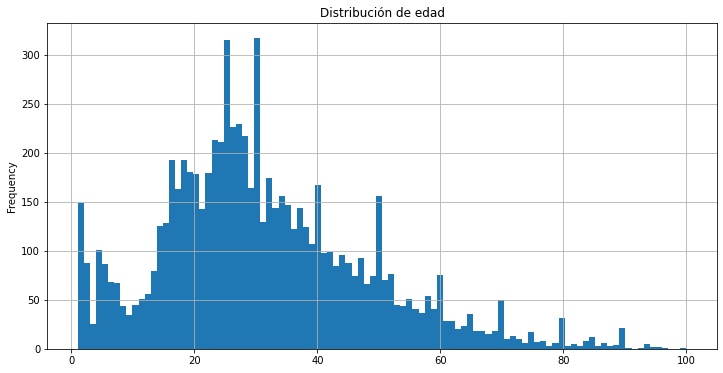

In [14]:
# Crea un gráfico de barras para visualizar la distribución de edad
labels['real_age'].plot(kind='hist', bins=100, figsize=(12, 6), grid=True, title='Distribución de edad')

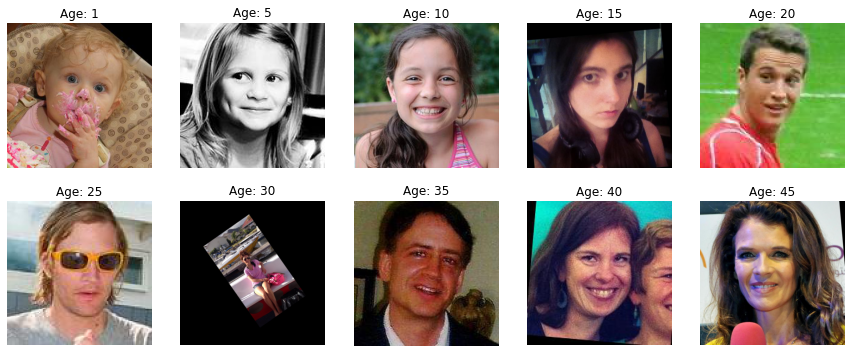

In [15]:
# Imprime de 10 a 15 fotos para diferentes edades en la pantalla para obtener una impresión general del conjunto de datos
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

# Crea una lista de edades para las que se mostrarán las fotos
ages = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45]

# Crea una figura con 5 columnas y 2 filas
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))

# Recorre las edades y muestra las fotos
for i, age in enumerate(ages):
    # Carga la imagen
    image = Image.open(files_path + labels[labels['real_age'] == age]['file_name'].iloc[0])
    # Muestra la imagen en la posición correspondiente
    axes.flat[i].imshow(image)
    # Establece el título de la imagen
    axes.flat[i].set_title("Age: " + str(age))
    # Desactiva los ejes
    axes.flat[i].axis('off')

# Muestra la figura
plt.show()

### Conclusiones

- Los tipos de dato son correctos en ambas columnas.
- No existen valores ausentes en el dataset.
- La distribución de los datos muestra una importante cantidad de registros con edades cercanas a la mayoría de edad, lo cual es ideal para la exactitud del modelo.

## Modelado

Define las funciones necesarias para entrenar tu modelo en la plataforma GPU y crear un solo script que las contenga todas junto con la sección de inicialización.

Para facilitar esta tarea, puedes definirlas en este notebook y ejecutar un código listo en la siguiente sección para componer automáticamente el script.

Los revisores del proyecto también verificarán las definiciones a continuación, para que puedan comprender cómo construiste el modelo.

In [16]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [17]:
def load_train(path):
    """
    Carga la parte de entrenamiento del conjunto de datos desde la ruta.
    """
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    return train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345,
        subset='training',
    )

In [18]:
def load_test(path):
    """
    Carga la parte de validación/prueba del conjunto de datos desde la ruta
    """
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    return test_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345,
        subset='validation',
    )

In [19]:
def create_model(input_shape):
    """
    Define el modelo
    """
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)

    # Make backbone trainable for fine-tuning
    for layer in backbone.layers:
        layer.trainable = True
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(BatchNormalization())  # Add Batch Normalization
    model.add(Dropout(0.5))          # Add Dropout
    model.add(Dense(128, activation='relu'))  # More complex classifier
    model.add(Dropout(0.5))          # Add another Dropout
    model.add(Dense(1, activation='linear')) # Linear activation for regression

    model.compile(optimizer=Adam(learning_rate=0.0001),  # Smaller learning rate
                  loss='mae', # Mean Absolute Error for regression
                  metrics=['mae']) # Mean Absolute Error for regression
    
    return model

In [20]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    """
    Entrena el modelo dados los parámetros
    """
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )

    return model

### Prepara el script para ejecutarlo en la plataforma GPU

Una vez que hayas definido las funciones necesarias, puedes redactar un script para la plataforma GPU, descargarlo a través del menú "File|Open..." (Archivo|Abrir) y cargarlo más tarde para ejecutarlo en la plataforma GPU.

Nota: el script debe incluir también la sección de inicialización. A continuación se muestra un ejemplo.

In [21]:
# prepara un script para ejecutarlo en la plataforma GPU

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Resultado

Coloca aquí el resultado de la plataforma GPU como una celda Markdown.

2023-08-30 20:10:13.102978: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6

2023-08-30 20:10:13.104634: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6

Using TensorFlow backend.

Found 5694 validated image filenames.

Found 1897 validated image filenames.

2023-08-30 20:10:14.157840: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1

2023-08-30 20:10:14.205787: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

2023-08-30 20:10:14.205988: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 

pciBusID: 0000:00:1e.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0

coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s

2023-08-30 20:10:14.206029: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1

2023-08-30 20:10:14.206065: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

2023-08-30 20:10:14.208144: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10

2023-08-30 20:10:14.208536: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10

2023-08-30 20:10:14.210682: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10

2023-08-30 20:10:14.211926: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10

2023-08-30 20:10:14.211986: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

2023-08-30 20:10:14.212104: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

2023-08-30 20:10:14.212388: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

2023-08-30 20:10:14.212554: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0

2023-08-30 20:10:14.212921: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA

2023-08-30 20:10:14.220016: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300020000 Hz

2023-08-30 20:10:14.220595: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4917f60 initialized for platform Host (this does not guarantee that XLA will be used). Devices:

2023-08-30 20:10:14.220623: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version

2023-08-30 20:10:14.305281: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

2023-08-30 20:10:14.305576: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x33fa7c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:

2023-08-30 20:10:14.305598: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0

2023-08-30 20:10:14.305831: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

2023-08-30 20:10:14.306025: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 

pciBusID: 0000:00:1e.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0

coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s

2023-08-30 20:10:14.306078: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1

2023-08-30 20:10:14.306097: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

2023-08-30 20:10:14.306127: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10

2023-08-30 20:10:14.306142: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10

2023-08-30 20:10:14.306157: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10

2023-08-30 20:10:14.306176: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10

2023-08-30 20:10:14.306201: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

2023-08-30 20:10:14.306285: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

2023-08-30 20:10:14.306512: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

2023-08-30 20:10:14.306667: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0

2023-08-30 20:10:14.306705: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1

2023-08-30 20:10:14.583043: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:

2023-08-30 20:10:14.583095: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 

2023-08-30 20:10:14.583105: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 

2023-08-30 20:10:14.583326: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

2023-08-30 20:10:14.583563: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

2023-08-30 20:10:14.583742: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.

2023-08-30 20:10:14.583786: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 14988 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1e.0, compute capability: 7.0)

Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5


    8192/94765736 [..............................] - ETA: 1s
11108352/94765736 [==>...........................] - ETA: 0s
23224320/94765736 [======>.......................] - ETA: 0s
35274752/94765736 [==========>...................] - ETA: 0s
47357952/94765736 [=============>................] - ETA: 0s
59342848/94765736 [=================>............] - ETA: 0s
71254016/94765736 [=====================>........] - ETA: 0s
83353600/94765736 [=========================>....] - ETA: 0s
94773248/94765736 [==============================] - 0s 0us/step

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

WARNING:tensorflow:sample_weight modes were coerced from

  ...

    to  

  ['...']

WARNING:tensorflow:sample_weight modes were coerced from

  ...

    to  

  ['...']

Train for 178 steps, validate for 60 steps

Epoch 1/20

2023-08-30 20:10:26.793346: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

2023-08-30 20:10:27.037174: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

178/178 - 47s - loss: 18.9913 - mae: 18.9929 - val_loss: 20.7450 - val_mae: 20.7392

Epoch 2/20

178/178 - 37s - loss: 11.0330 - mae: 11.0335 - val_loss: 15.2174 - val_mae: 15.1963

Epoch 3/20

178/178 - 38s - loss: 9.6856 - mae: 9.6858 - val_loss: 11.7398 - val_mae: 11.7008

Epoch 4/20

178/178 - 37s - loss: 8.8970 - mae: 8.8967 - val_loss: 9.4888 - val_mae: 9.4789

Epoch 5/20

178/178 - 38s - loss: 8.2782 - mae: 8.2783 - val_loss: 9.4880 - val_mae: 9.4692

Epoch 6/20

178/178 - 38s - loss: 7.7549 - mae: 7.7544 - val_loss: 8.4434 - val_mae: 8.4311

Epoch 7/20

178/178 - 38s - loss: 7.3716 - mae: 7.3715 - val_loss: 7.2046 - val_mae: 7.2218

Epoch 8/20

178/178 - 38s - loss: 7.0582 - mae: 7.0584 - val_loss: 7.1421 - val_mae: 7.1675

Epoch 9/20

178/178 - 38s - loss: 6.9327 - mae: 6.9331 - val_loss: 6.6026 - val_mae: 6.6214

Epoch 10/20

178/178 - 38s - loss: 6.5114 - mae: 6.5118 - val_loss: 6.9021 - val_mae: 6.8872

Epoch 11/20

178/178 - 38s - loss: 6.2694 - mae: 6.2693 - val_loss: 7.1536 - val_mae: 7.1802

Epoch 12/20

178/178 - 37s - loss: 6.3349 - mae: 6.3348 - val_loss: 7.0322 - val_mae: 7.0699

Epoch 13/20

178/178 - 38s - loss: 6.1867 - mae: 6.1865 - val_loss: 7.2903 - val_mae: 7.3141

Epoch 14/20

178/178 - 38s - loss: 5.9097 - mae: 5.9095 - val_loss: 6.8426 - val_mae: 6.8547

Epoch 15/20

178/178 - 45s - loss: 5.9666 - mae: 5.9659 - val_loss: 7.3611 - val_mae: 7.3948

Epoch 16/20

178/178 - 47s - loss: 5.7515 - mae: 5.7519 - val_loss: 6.9621 - val_mae: 6.9977

Epoch 17/20

178/178 - 40s - loss: 5.7067 - mae: 5.7070 - val_loss: 6.4480 - val_mae: 6.4846

Epoch 18/20

178/178 - 38s - loss: 5.5690 - mae: 5.5690 - val_loss: 6.3827 - val_mae: 6.4090

Epoch 19/20

178/178 - 38s - loss: 5.3786 - mae: 5.3781 - val_loss: 7.0968 - val_mae: 7.0965

Epoch 20/20

178/178 - 38s - loss: 5.4054 - mae: 5.4051 - val_loss: 6.4463 - val_mae: 6.4509

WARNING:tensorflow:sample_weight modes were coerced from

  ...

    to  

  ['...']

60/60 - 9s - loss: 6.4463 - mae: 6.4509

Test MAE: 6.4509

## Conclusiones

El modelo muestra un rendimiento prometedor en su capacidad para estimar la edad de una persona basada en imágenes de su rostro. El error absoluto medio (`MAE`) en el conjunto de prueba es de `6.4509` años, lo cual indica que, en promedio, la predicción del modelo se desvía por menos de 7 años con respecto a la edad real.

El modelo tiene el potencial de ser implementado en las tiendas Good Seed como una primera línea de defensa para asegurar el cumplimiento de la ley, aunque se recomendaría utilizarlo en conjunto con otros métodos de verificación para maximizar la eficacia.

# Lista de revisión

- [x]  El Notebook estaba abierto 
- [x]  El código no tiene errores
- [x]  Las celdas con el código han sido colocadas en el orden de ejecución
- [x]  Se realizó el análisis exploratorio de datos
- [x]  Los resultados del análisis exploratorio de datos se presentan en el notebook final
- [x]  El valor EAM del modelo no es superior a 8
- [x]  El código de entrenamiento del modelo se copió en el notebook final
- [x]  El resultado de entrenamiento del modelo se copió en el notebook final
- [x]  Los hallazgos se proporcionaron con base en los resultados del entrenamiento del modelo